## Train LSTM model on chartevents minute-by-minute data

In [103]:
import os

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

os.environ['TF_CUDNN_RESET_RND_GEN_STATE'] = '1'

In [104]:
import warnings
warnings.filterwarnings("ignore")

In [105]:
import configparser
import pandas as pd
import sys
import os
from sqlalchemy import text

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import ConnectionDetails, DataTransfer


config = configparser.ConfigParser()
config.read('../config.ini')

print(*(x[1] for x in config.items('database')))

dt = DataTransfer(ConnectionDetails(*(x[1] for x in config.items('database'))))


sql_query = """
            select count(*) as cnt
               , max(charttime) - min(charttime) as timediff
               , extract(days from max(charttime) - min(charttime)) as timediff_days
            from mart.chartevents_original
            group by hadm_id
"""

df = dt.fetch_data(text(sql_query))

postgresql mimic-iv_db agabitas_non_su aGaBiTaS dws-login-01.informatik.uni-mannheim.de 5432


In [106]:
df

,cnt,timediff,timediff_days
0,257,6 days 10:02:00,6.0
1,94,2 days 11:08:00,2.0
2,139,2 days 16:26:00,2.0
3,182,4 days 13:10:00,4.0
4,77,2 days 12:21:00,2.0
...,...,...,...
4368,531,11 days 17:00:00,11.0
4369,185,4 days 02:00:00,4.0
4370,166,3 days 11:00:00,3.0
4371,96,2 days 21:06:00,2.0


<Axes: xlabel='timediff', ylabel='cnt'>

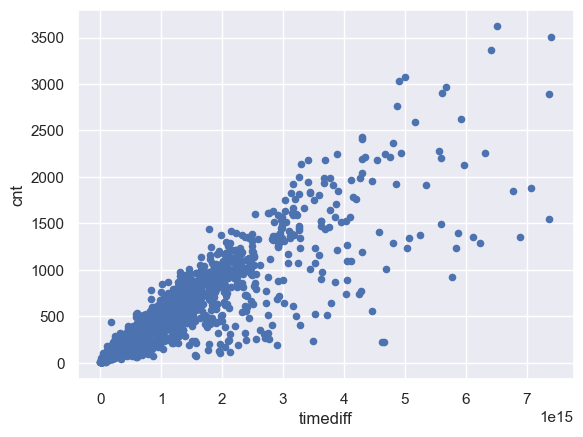

In [107]:
df.loc[(df.timediff < pd.Timedelta(days=90)) & (df.cnt < 150000)].plot.scatter(x='timediff', y='cnt')

<Axes: xlabel='timediff_days', ylabel='cnt'>

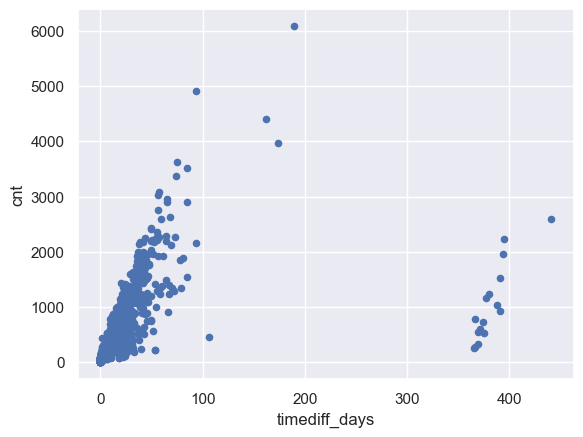

In [108]:
df.loc[(df.timediff_days < 720) & (df.cnt < 150000)].plot.scatter(x='timediff_days', y='cnt')

# maybe truncate those with > 1 year of admission

<Axes: xlabel='timediff_days', ylabel='cnt'>

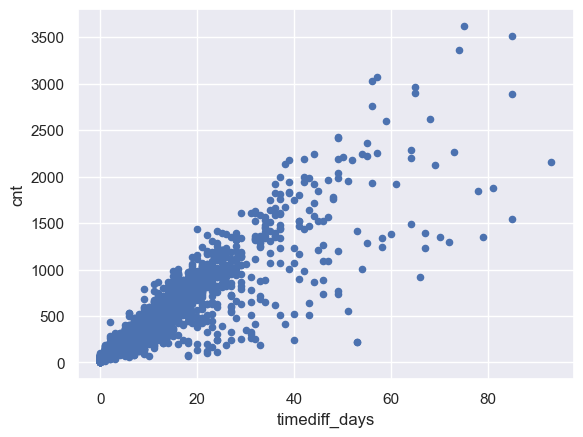

In [109]:
df.loc[(df.timediff_days < 100) & (df.cnt < 4000)].plot.scatter(x='timediff_days', y='cnt')

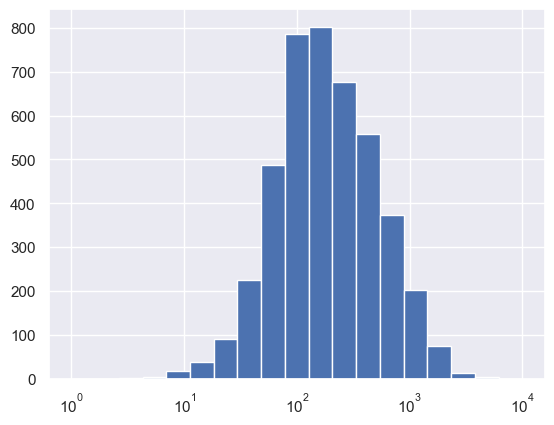

In [110]:
import matplotlib.pyplot as plt
import numpy as np

log_bins = np.logspace(0, 4, 20)


df.loc[(df.timediff_days < 200) & (df.cnt < 150000)]['cnt'].hist(bins=log_bins)

# plt.yscale('log')
plt.xscale('log')

# power distribution

In [111]:
# sliding window (128, 256, 512 or more (up to 4096) last events with step of 256, 512 or 1024) 
# vector size up to 256 (ask ChatGPT)
# add how much time they already spent in the ICU
# consider splitting into train and test by time 
# switch from LabelEncoding to OHE (possibly), may be TargetEncoding 

In [ ]:
import configparser
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import ConnectionDetails, DataTransfer

config = configparser.ConfigParser()
config.read('../config.ini')

print(*(x[1] for x in config.items('database')))

dt = DataTransfer(ConnectionDetails(*(x[1] for x in config.items('database'))))

sql_query = """
SELECT *
FROM mart.chartevents_original
"""

chartevents_df = dt.fetch_data(text(sql_query))

postgresql mimic-iv_db agabitas_non_su aGaBiTaS dws-login-01.informatik.uni-mannheim.de 5432


In [ ]:
chartevents_df

In [ ]:
chartevents_df.shape

In [ ]:
chartevents_df.info(memory_usage='deep')

In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# tf.config.experimental.set_memory_growth(physical_devices[1], enable=True)
# tf.config.experimental.set_memory_growth(physical_devices[2], enable=True)

In [ ]:
physical_devices

In [ ]:
connection = ConnectionDetails(*(x[1] for x in config.items('database')))

In [ ]:
from py_models import chartevent_tests, LSTMModel

lstm = LSTMModel(chartevent_tests, connection)

In [ ]:
X, y = lstm.read_transform_data(chartevents_df, classification=True)

In [ ]:
X_train, X_test, y_train, y_test = lstm.split_data(X, y)

lstm.train_model(X_train, y_train, epochs=5, batch_size=16)

predictions = lstm.predict(X_test)

In [ ]:
lstm_results = []

In [ ]:
from collections import Counter


def transform_item(x):
    return list(x).index(1)

y_test = [transform_item(x) for x in y_test]

Counter(y_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')  # F1-score for multi-class



lstm_results.append({'model': 'original', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
mae = abs(predictions - y_test).mean()

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)


lstm_results.append({'model': 'original', 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

### with sliding window

In [ ]:
window_size = [128, 256, 512]
step_size = [64, 128, 256]

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[0], step=step_size[0], classification=True)

In [ ]:
X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

In [ ]:
y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_128_s_64', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
Counter(y_test)

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[1], step=step_size[0], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_256_s_64', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[2], step=step_size[0], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_512_s_64', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[1], step=step_size[1], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_256_s_128', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[2], step=step_size[1], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_512_s_128', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=1024, step=step_size[1], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results = []
lstm_results.append({'model': 'w_1024_s_128', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=1024, step=step_size[0], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_1024_s_64', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=1024, step=step_size[2], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_1024_s_256', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
lstm_results


In [ ]:


lstm_results[3]["model"] = "w_512_s_256"
lstm_results[4]["model"] = "w_512_s_128"


lstm_results = sorted(lstm_results, key=lambda x: x['model'])

In [ ]:
pd.DataFrame(lstm_results, columns=['model', 'accuracy', 'precision', 'recall', 'f1'])

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[2], step=step_size[2], classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_512_s_256', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=1024, step=32, classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_1024_s_32', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=128, step=32, classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_128_s_32', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=256, step=32, classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_256_s_32', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=512, step=32, classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

lstm_results.append({'model': 'w_512_s_32', 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [ ]:
lstm_results

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[2], step=step_size[1])

X_train, X_test, y_train, y_test = lstm.split_data(X, y)

lstm.train_model(X_train, y_train, epochs=50, batch_size=8)

predictions = lstm.predict(X_test)

mae = abs(predictions - y_test).mean()

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)


lstm_results.append({'model': 'sliding window 512/128', 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[0], step=32)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)

lstm.train_model(X_train, y_train, epochs=50, batch_size=8)

predictions = lstm.predict(X_test)

mae = abs(predictions - y_test).mean()

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)


lstm_results.append({'model': 'sliding window 128/32', 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

In [ ]:
pd.DataFrame(lstm_results)

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=window_size[1], step=32)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)

lstm.train_model(X_train, y_train, epochs=50, batch_size=8)

predictions = lstm.predict(X_test)

mae = abs(predictions - y_test).mean()

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)


lstm_results.append({'model': 'sliding window 256/32', 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

pd.DataFrame(lstm_results)

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=64, step=32)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)

lstm.train_model(X_train, y_train, epochs=50, batch_size=8)

predictions = lstm.predict(X_test)

mae = abs(predictions - y_test).mean()

mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)


lstm_results.append({'model': 'sliding window 64/32', 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

In [ ]:
pd.DataFrame(lstm_results)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Data preparation
data = [
    {'hidden_sizes': 2, 'attention_heads': 4, 'lr': 0.0001, 'ws': 64, 'ss': 32, 'accuracy': 0.6497, 'precision': 0.6423, 'recall': 0.6497, 'f1': 0.6433},
    {'hidden_sizes': 2, 'attention_heads': 8, 'lr': 0.0001, 'ws': 64, 'ss': 32, 'accuracy': 0.6321, 'precision': 0.6339, 'recall': 0.6321, 'f1': 0.6329},
    {'hidden_sizes': 2, 'attention_heads': 16, 'lr': 0.0001, 'ws': 64, 'ss': 32, 'accuracy': 0.6507, 'precision': 0.6453, 'recall': 0.6507, 'f1': 0.6474},
    {'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'ws': 64, 'ss': 32, 'accuracy': 0.6687, 'precision': 0.6689, 'recall': 0.6687, 'f1': 0.6682},
    {'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'ws': 64, 'ss': 32, 'accuracy': 0.6597, 'precision': 0.6615, 'recall': 0.6597, 'f1': 0.6599},
    {'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'ws': 128, 'ss': 32, 'accuracy': 0.7302, 'precision': 0.7267, 'recall': 0.7302, 'f1': 0.7279},
    {'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'ws': 128, 'ss': 64, 'accuracy': 0.5190, 'precision': 0.5050, 'recall': 0.5190, 'f1': 0.5090},
    {'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'ws': 256, 'ss': 64, 'accuracy': 0.5588, 'precision': 0.5521, 'recall': 0.5588, 'f1': 0.5550},
    {'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'ws': 512, 'ss': 64, 'accuracy': 0.5981, 'precision': 0.5746, 'recall': 0.5981, 'f1': 0.5798},
    {'hidden_sizes': 16, 'attention_heads': 16, 'lr': 0.0001, 'ws': 512, 'ss': 64, 'accuracy': 0.6067, 'precision': 0.5852, 'recall': 0.6067, 'f1': 0.5883},
]

data = [
    {
        'window_size': 128,
        'step_size': 64,
        'accuracy': 0.5542597991577584,
        'precision': 0.5093726306031955,
        'recall': 0.5125251122336177,
        'f1': 0.4762165578045954
    },
    {
        'window_size': 256,
        'step_size': 64,
        'accuracy': 0.48898265353961556,
        'precision': 0.45560057463647136,
        'recall': 0.43937811830156553,
        'f1': 0.3829053649030658
    },
    {
        'window_size': 256,
        'step_size': 128,
        'accuracy': 0.47400346620450606,
        'precision': 0.4187971506687764,
        'recall': 0.4353735632183908,
        'f1': 0.4192714894382011
    },
    {
        'window_size': 512,
        'step_size': 64,
        'accuracy': 0.5826161790017211,
        'precision': 0.5544603350189633,
        'recall': 0.5313070647816213,
        'f1': 0.5150850431476672
    },
    {
        'window_size': 512,
        'step_size': 128,
        'accuracy': 0.49114331723027377,
        'precision': 0.4421741008622149,
        'recall': 0.44496036457396415,
        'f1': 0.42957186748597387
    },
    {
        'window_size': 512,
        'step_size': 256,
        'accuracy': 0.4197183098591549,
        'precision': 0.38350432082681957,
        'recall': 0.38379408622537586,
        'f1': 0.3781658581658582
    },
    {
        'window_size': 1024,
        'step_size': 64,
        'accuracy': 0.6124401913875598,
        'precision': 0.5284080554036814,
        'recall': 0.519349419205741,
        'f1': 0.5174063005452189
    },
    {
        'window_size': 1024,
        'step_size': 256,
        'accuracy': 0.4878048780487805,
        'precision': 0.4255113322277501,
        'recall': 0.42392651454399655,
        'f1': 0.4223861764114929
    }
]

# Convert to DataFrame
df = pd.DataFrame(data)

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap of correlation
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Feature importance using Random Forest
X = df[['window_size', 'step_size']]
y = df['accuracy']  # Using accuracy as the main target metric

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importance plot
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance for Accuracy (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Return correlation and feature importance values
corr_matrix, feature_importance


In [ ]:
 import pandas as pd

# Define the data

data = {
    "Window Size": [128, 128, 256, 256, 256, 512, 512, 512, 512, 1024, 1024, 1024],
    "Step Size": [32, 64, 32, 64, 128, 32, 64, 128, 256, 32, 64, 256],
    "Accuracy": [0.6021, 0.5543, 0.6330, 0.4890, 0.4740, 0.6904, 0.5826, 0.4911, 0.4197, 0.7204, 0.6124, 0.4878],
    "Precision": [0.5670, 0.5094, 0.5916, 0.4556, 0.4188, 0.5916, 0.5545, 0.4422, 0.3835, 0.6553, 0.5284, 0.4255],
    "Recall": [0.5681, 0.5125, 0.5933, 0.4394, 0.4354, 0.5933, 0.5313, 0.4450, 0.3838, 0.6408, 0.5193, 0.4239],
    "F1 Score": [0.5613, 0.4762, 0.5873, 0.3829, 0.4193, 0.5873, 0.5151, 0.4296, 0.3782, 0.6338, 0.5174, 0.4224]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure style
sns.set(style="whitegrid")

# Create the first figure (Metrics by Window Size)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Window Size", y="Accuracy", marker="o", label="Accuracy")
sns.lineplot(data=df, x="Window Size", y="Precision", marker="o", label="Precision")
sns.lineplot(data=df, x="Window Size", y="Recall", marker="o", label="Recall")
sns.lineplot(data=df, x="Window Size", y="F1 Score", marker="o", label="F1 Score")
plt.title("Performance Metrics by Window Size")
plt.xlabel("Window Size")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

# Create the second figure (Metrics by Step Size)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Step Size", y="Accuracy", marker="o", label="Accuracy")
sns.lineplot(data=df, x="Step Size", y="Precision", marker="o", label="Precision")
sns.lineplot(data=df, x="Step Size", y="Recall", marker="o", label="Recall")
sns.lineplot(data=df, x="Step Size", y="F1 Score", marker="o", label="F1 Score")
plt.title("Performance Metrics by Step Size")
plt.xlabel("Step Size")
plt.ylabel("Metric Value")
plt.legend()
plt.show()


In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=1024, step=32, classification=True)

X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_train, y_train, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

In [ ]:
f1 = f1_score(y_test, predictions, average=None)

In [ ]:
# Oversampling

import numpy as np
from sklearn.utils import resample

# Augment the dataset to address class imbalance
def augment_data(X, y):
    # Identify the class distribution
    class_counts = Counter(y)
    max_count = max(class_counts.values())

    X_augmented, y_augmented = [], []

    for label in class_counts.keys():
        # Get all samples of the current class
        X_class = X[y == label]
        y_class = y[y == label]

        # Random oversampling to balance the classes
        if len(X_class) < max_count:
            X_resampled, y_resampled = resample(
                X_class,
                y_class,
                replace=True,
                n_samples=max_count - len(X_class),
                random_state=42
            )
            X_augmented.append(X_resampled)
            y_augmented.append(y_resampled)

    # Concatenate original and augmented data
    X_balanced = np.vstack((X, *X_augmented))
    y_balanced = np.hstack((y, *y_augmented))

    return X_balanced, y_balanced


# Example usage:
X_augmented, y_augmented = augment_data(X_train, np.argmax(y_train, axis=1))

# Check the new class distribution
print("Class distribution after augmentation:", Counter(y_augmented))

In [ ]:
from tensorflow.keras.utils import to_categorical

y_augmented = to_categorical(y_augmented, num_classes=3)

In [ ]:
Counter(np.argmax(y_train, axis=1))

In [ ]:
accuracy, precision, recall, f1

In [ ]:
lstm = LSTMModel(chartevent_tests, connection)

X, y = lstm.read_transform_data(chartevents_df, with_sliding_window=True, size=1024, step=32, classification=True)

# X_train, X_test, y_train, y_test = lstm.split_data(X, y)


lstm.train_model(X_augmented, y_augmented, epochs=30, batch_size=8)

predictions = lstm.predict(X_test)

# y_test = [transform_item(x) for x in y_test]


accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1-Score (for multi-class)
precision = precision_score(y_test, predictions, average='macro')  # 'macro' averages precision across all classes
recall = recall_score(y_test, predictions, average='macro')  # 'macro' gives equal weight to all classes
f1 = f1_score(y_test, predictions, average='macro')

In [ ]:
accuracy, precision, recall, f1

In [ ]:
f1_score(y_test, predictions, average=None)

In [ ]:
!pip3 install shap

In [ ]:
import shap
DE = shap.DeepExplainer(new_model, X_train) # X_train is 3d numpy.ndarray
shap_values = DE.shap_values(X_test, check_additivity=False) # X_validate is 3d numpy.ndarray

shap.initjs()
shap.summary_plot(
    shap_values[0],
    X_test,
    feature_names=lstm.get_feature_names(),
    max_display=50,
    plot_type='bar')

In [ ]:
lstm.model.input

In [ ]:
new_model.input

In [ ]:
from tensorflow import keras

new_model_input = keras.layers.Input(shape=(1024, 168))
new_model_output = lstm.model(new_model_input)
new_model = keras.models.Model(inputs=new_model_input, outputs=new_model_output)

In [ ]:
X_test.shape

In [ ]:
X_test[0]

In [80]:
predictions = lstm.model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step


In [90]:
from sklearn.metrics import accuracy_score
import numpy as np

def permutation_importance(model, X_test, y_test):
    predictions = model.predict(X_test)
    baseline_acc = accuracy_score(y_test, np.argmax(predictions, axis=1))
    feature_importance = []

    for i in range(X_test.shape[2]):  # Iterate over features
        X_test_permuted = X_test.copy()

        # Shuffle feature `i` across all timesteps
        for j in range(X_test.shape[0]):  # Iterate over samples
            np.random.shuffle(X_test_permuted[j, :, i])

        new_acc = accuracy_score(
            y_test,
            np.argmax(model.predict(X_test_permuted), axis=1)
        )
        feature_importance.append(baseline_acc - new_acc)

    return feature_importance

# Run feature importance calculation
feature_importance = permutation_importance(lstm.model, X_test, y_test)

# Print feature importance
for i, f_imp in enumerate(feature_importance):
    print(f"{i}: {f_imp}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step
(812, 3)
[[9.9993050e-01 6.7159941e-05 2.3566129e-06]
 [1.3438442e-02 7.4309170e-02 9.1225237e-01]
 [2.3464637e-01 7.2924800e-02 6.9242889e-01]
 ...
 [4.8147948e-04 6.8604378e-03 9.9265814e-01]
 [1.0214632e-03 1.1960539e-02 9.8701799e-01]
 [6.9028884e-04 1.4416054e-02 9.8489362e-01]]
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step
26/26 ━━━━━━━━━━━━

In [93]:
len(chartevents_df.columns.tolist())

174

In [94]:
chartevent_tests = [
    'hr_value',
    'hr_warning',
    'rr_value',
    'rr_warning',
    'abpm_value',
    'abpm_warning',
    'abpd_value',
    'abpd_warning',
    'abps_value',
    'abps_warning',
    'nbpm_value',
    'nbpm_warning',
    'nbpd_value',
    'nbpd_warning',
    'nbps_value',
    'nbps_warning',
    'forehead_spo2_value',
    'forehead_spo2_warning',
    'spo2_desat_limit_value',
    'spo2_desat_limit_warning',
    'temperature_c_value',
    'temperature_c_warning',
    'temperature_f_value',
    'temperature_f_warning',
    'cerebral_t_value',
    'cerebral_t_warning',
    'eye_opening_value',
    'eye_opening_warning',
    'motor_response_value',
    'motor_response_warning',
    'verbal_response_value',
    'verbal_response_warning',
    'pupil_response_l_value',
    'pupil_response_l_warning',
    'pupil_response_r_value',
    'pupil_response_r_warning',
    'ph_arterial_value',
    'ph_arterial_warning',
    'ph_venous_value',
    'ph_venous_warning',
    'hco3_serum_value',
    'hco3_serum_warning',
    'sodium_serum_value',
    'sodium_serum_warning',
    'potassium_serum_value',
    'potassium_serum_warning',
    'chloride_serum_value',
    'chloride_serum_warning',
    'bun_value',
    'bun_warning',
    'ventilator_mode_value',
    'ventilator_mode_warning',
    'ventilator_mode_hamilton_value',
    'ventilator_mode_hamilton_warning',
    'ventilator_type_value',
    'ventilator_type_warning',
    'bis_emg_value',
    'bis_emg_warning',
    'bis_index_range_value',
    'bis_index_range_warning',
    'delirium_assessment_value',
    'delirium_assessment_warning',
    'cam_icu_altered_loc_value',
    'cam_icu_altered_loc_warning',
    'cam_icu_disorganized_thinking_value',
    'cam_icu_disorganized_thinking_warning',
    'cam_icu_inattention_value',
    'cam_icu_inattention_warning',
    'motor_deficit_value',
    'motor_deficit_warning',
    'goal_richmond_ras_scale_value',
    'goal_richmond_ras_scale_warning',
    'pnc_1_appearance_value',
    'pnc_1_appearance_warning',
    'pnc_1_bolus_ml_value',
    'pnc_1_bolus_ml_warning',
    'pnc_1_infusion_rate_ml_hr_value',
    'pnc_1_infusion_rate_ml_hr_warning',
    'pnc_1_location_value',
    'pnc_1_location_warning',
    'pnc_1_medication_value',
    'pnc_1_medication_warning',
    'pnc_1_motor_deficit_value',
    'pnc_1_motor_deficit_warning',
    'pnc_2_appearance_value',
    'pnc_2_appearance_warning',
    'pnc_2_infusion_rate_ml_hr_value',
    'pnc_2_infusion_rate_ml_hr_warning',
    'pnc_2_location_value',
    'pnc_2_location_warning',
    'pnc_2_medication_value',
    'pnc_2_medication_warning',
    'pnc_2_motor_deficit_value',
    'pnc_2_motor_deficit_warning',
    'cpot_pain_assessment_method_value',
    'cpot_pain_assessment_method_warning',
    'cpot_pain_management_value',
    'cpot_pain_management_warning',
    'pain_level_value',
    'pain_level_warning',
    'pain_level_acceptable_value',
    'pain_level_acceptable_warning',
    'pain_level_acceptable_preintervention_value',
    'pain_level_acceptable_preintervention_warning',
    'pain_level_response_value',
    'pain_level_response_warning',
    'pain_management_value',
    'pain_management_warning',
    'nmb_medication_value',
    'nmb_medication_warning',
    'epidural_infusion_rate_ml_hr_value',
    'epidural_infusion_rate_ml_hr_warning',
    'epidural_medication_value',
    'epidural_medication_warning',
    'pca_1_hour_limit_value',
    'pca_1_hour_limit_warning',
    'pca_attempt_value',
    'pca_attempt_warning',
    'pca_basal_rate_ml_hour_value',
    'pca_basal_rate_ml_hour_warning',
    'pca_bolus_value',
    'pca_bolus_warning',
    'pca_cleared_value',
    'pca_cleared_warning',
    'pca_concentrations_value',
    'pca_concentrations_warning',
    'pca_dose_value',
    'pca_dose_warning',
    'pca_inject_value',
    'pca_inject_warning',
    'pca_lockout_min_value',
    'pca_lockout_min_warning',
    'pca_medication_value',
    'pca_medication_warning',
    'pca_total_dose_value',
    'pca_total_dose_warning',
    'tof_response_value',
    'tof_response_warning',
    'tof_twitch_value',
    'tof_twitch_warning',
    'current_used_ma_value',
    'current_used_ma_warning',
    'daily_wake_up_value',
    'daily_wake_up_warning',
    'daily_wake_up_deferred_value',
    'daily_wake_up_deferred_warning',
    'untoward_effect_value',
    'untoward_effect_warning',
    'pt_splint_location_1_value',
    'pt_splint_location_1_warning',
    'pt_splint_location_2_value',
    'pt_splint_location_2_warning',
    'pt_splint_status_1_value',
    'pt_splint_status_1_warning',
    'pt_splint_status_2_value',
    'pt_splint_status_2_warning',
    'ptt_value',
    'ptt_warning',
    'inr_value',
    'inr_warning',
    'ast_value',
    'ast_warning',
    'alt_value',
    'alt_warning',
    'direct_bilirubin_value',
    'direct_bilirubin_warning',
    'total_bilirubin_value',
    'total_bilirubin_warning'
]

len(chartevent_tests)

168

In [101]:
fi_lstm = {}

for i, f_imp in enumerate(feature_importance):
    fi_lstm[chartevent_tests[i]] = f_imp


pd.DataFrame(sorted(fi_lstm.items(), key=lambda x: x[1], reverse=True), columns=['Feature', 'Importance'])

,Feature,Importance
0,goal_richmond_ras_scale_value,0.023399
1,ventilator_mode_hamilton_value,0.019704
2,ventilator_mode_value,0.018473
3,cam_icu_inattention_value,0.011084
4,daily_wake_up_value,0.009852
...,...,...
163,ph_arterial_warning,-0.003695
164,pain_level_value,-0.003695
165,abpd_value,-0.004926
166,spo2_desat_limit_value,-0.004926


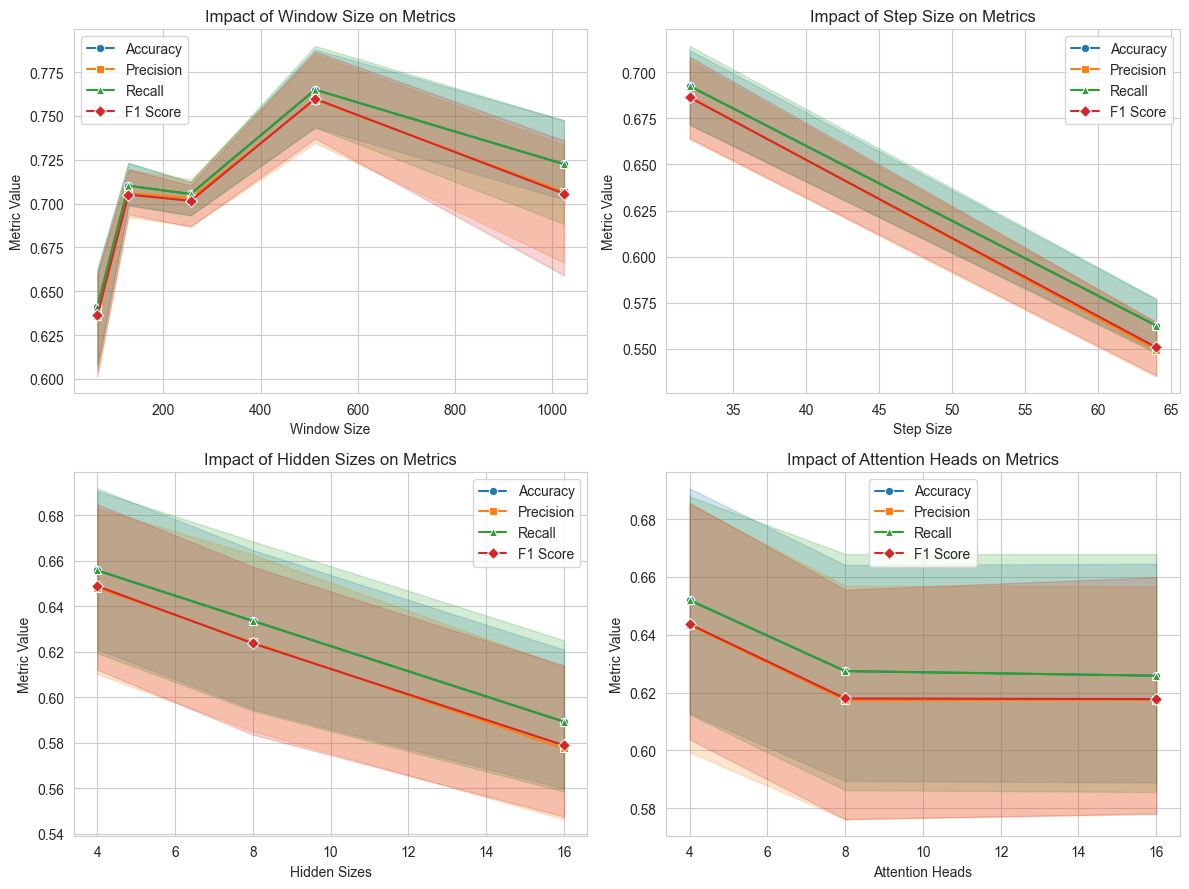

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = [
        # 64 32
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.6686838124054463, 'precision': 0.6689388831451342, 'recall': 0.6686838124054463, 'f1': 0.6681977012573284},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.6597441892449457, 'precision': 0.6615441339594744, 'recall': 0.6597441892449457, 'f1': 0.6599131001852502},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.6648328978132306, 'precision': 0.6601963783481094, 'recall': 0.6648328978132306, 'f1': 0.6620166004698187},

        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.6590565259249072, 'precision': 0.6579714829751007, 'recall': 0.6590565259249072, 'f1': 0.6583543079600783},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.6627699078531151, 'precision': 0.6533892209546757, 'recall': 0.6627699078531151, 'f1': 0.6550552140369765},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.6629074405171228, 'precision': 0.6555037349726716, 'recall': 0.6629074405171228, 'f1': 0.655567620131894},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 16, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.6039059276578187, 'precision': 0.5891701490598639, 'recall': 0.6039059276578187, 'f1': 0.5898515564342421},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 16, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.6459909228441755, 'precision': 0.6517335480084228, 'recall': 0.6459909228441755, 'f1': 0.6445608902797659},
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 16, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.6648328978132306, 'precision': 0.6570792658568123, 'recall': 0.6648328978132306, 'f1': 0.6594627555205373},

        # 128 32
        {'window_size': 128, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7122914538644876, 'precision': 0.7116575223601708, 'recall': 0.7122914538644876, 'f1': 0.7059612380062514},
        {'window_size': 128, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.6961184882533197, 'precision': 0.6910063929805368, 'recall': 0.6961184882533197, 'f1': 0.692215233296848},
        {'window_size': 128, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.7020769492679605, 'precision': 0.6940408285997987, 'recall': 0.7020769492679605, 'f1': 0.6945136297626806},
        {'window_size': 128, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7301668369084099, 'precision': 0.7266771825643012, 'recall': 0.7301668369084099, 'f1': 0.7278770237801048},

        # 128 64
        {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.5189504373177842, 'precision': 0.5050050096013798, 'recall': 0.5189504373177842, 'f1': 0.5090277338079364},
        {'window_size': 128, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5170068027210885, 'precision': 0.49778137175385306, 'recall': 0.5170068027210885, 'f1': 0.501674203077891},
        {'window_size': 128, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.5225137674117266, 'precision': 0.5045063872677596, 'recall': 0.5225137674117266, 'f1': 0.507820735502886},
        {'window_size': 128, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.5118237771298996, 'precision': 0.48632956927118914, 'recall': 0.5118237771298996, 'f1': 0.48529865861581994},
        {'window_size': 128, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5212180110139294, 'precision': 0.5067878533267406, 'recall': 0.5212180110139294, 'f1': 0.5079613659098089},
        {'window_size': 128, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.521865889212828, 'precision': 0.5214427551474453, 'recall': 0.521865889212828, 'f1': 0.5195365698665998},

        # 256 32
        {'window_size': 256, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.6818181818181818, 'precision': 0.6723767416493388, 'recall': 0.6818181818181818, 'f1': 0.6723540077020763},
        {'window_size': 256, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.7105890364317331, 'precision': 0.7134129008050768, 'recall': 0.7105890364317331, 'f1': 0.7100380315444804},
        {'window_size': 256, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.7136533878106912, 'precision': 0.7081898583498144, 'recall': 0.7136533878106912, 'f1': 0.7066077944332526},
        {'window_size': 256, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7102485529451822, 'precision': 0.7158872935744569, 'recall': 0.7102485529451822, 'f1': 0.7116888703717446},
        {'window_size': 256, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.710929519918284, 'precision': 0.705598637082852, 'recall': 0.710929519918284, 'f1': 0.7071666969522499},


        # 256 64
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.5902484763244257, 'precision': 0.5811382501441165, 'recall': 0.5902484763244257, 'f1': 0.583824329488905},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5588373183309893, 'precision': 0.5521417097945266, 'recall': 0.5588373183309893, 'f1': 0.554957080793801},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.5630567276136896, 'precision': 0.5606274252758068, 'recall': 0.5630567276136896, 'f1': 0.5595687510797487},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.5911861228316925, 'precision': 0.5723469360798458, 'recall': 0.5911861228316925, 'f1': 0.5723700240231224},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5691514299109236, 'precision': 0.56045791035059, 'recall': 0.5691514299109236, 'f1': 0.5636119588462342},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.5944678856071262, 'precision': 0.5858191757779151, 'recall': 0.5944678856071262, 'f1': 0.5793601530729421},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 16, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.5274261603375527, 'precision': 0.51370240565802, 'recall': 0.5274261603375527, 'f1': 0.5176215607098152},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 16, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5503984997655884, 'precision': 0.5395117945149247, 'recall': 0.5503984997655884, 'f1': 0.5415193248538774},
        {'window_size': 256, 'step_size': 64, 'hidden_sizes': 16, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.5405532114392874, 'precision': 0.5356014312262277, 'recall': 0.5405532114392874, 'f1': 0.5376842515342387},

        # 512 32
        {'window_size': 512, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7688195991091314, 'precision': 0.7664552149928617, 'recall': 0.7688195991091314, 'f1': 0.7624343325423193},
        {'window_size': 512, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.7474387527839643, 'precision': 0.7374457181532996, 'recall': 0.7474387527839643, 'f1': 0.7396980777406184},
        {'window_size': 512, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.8040089086859689, 'precision': 0.8010876176412024, 'recall': 0.8040089086859689, 'f1': 0.8023345342338146},
        {'window_size': 512, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7394209354120267, 'precision': 0.7318451655308563, 'recall': 0.7394209354120267, 'f1': 0.734502986937723},


        # 512 64
        {'window_size': 512, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.5903614457831325, 'precision': 0.5835283164665208, 'recall': 0.5903614457831325, 'f1': 0.5848662155518879},
        {'window_size': 512, 'step_size': 64, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.6325301204819277, 'precision': 0.6073111762307104, 'recall': 0.6325301204819277, 'f1': 0.6122531058406206},
        {'window_size': 512, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5981067125645438, 'precision': 0.5745542411232735, 'recall': 0.5981067125645438, 'f1': 0.5798294076506424},
        {'window_size': 512, 'step_size': 64, 'hidden_sizes': 8, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.5679862306368331, 'precision': 0.5694186221718371, 'recall': 0.5679862306368331, 'f1': 0.5638490618320205},
        {'window_size': 512, 'step_size': 64, 'hidden_sizes': 16, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.5748709122203098, 'precision': 0.5484974629603425, 'recall': 0.5748709122203098, 'f1': 0.5525480135515055},
        {'window_size': 512, 'step_size': 64, 'hidden_sizes': 16, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.6067125645438899, 'precision': 0.58523342031259, 'recall': 0.6067125645438899, 'f1': 0.5883008814836359},

        # 1024 32
        {'window_size': 1024, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7475369458128078, 'precision': 0.7334782520140589, 'recall': 0.7475369458128078, 'f1': 0.73598008929086},
        {'window_size': 1024, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 4, 'lr': 0.0001, 'accuracy': 0.7315270935960592, 'precision': 0.7199511024759419, 'recall': 0.7315270935960592, 'f1': 0.7219629070895585},
        {'window_size': 1024, 'step_size': 32, 'hidden_sizes': 8, 'attention_heads': 8, 'lr': 0.0001, 'accuracy': 0.6884236453201971, 'precision': 0.6664010210077969, 'recall': 0.6884236453201971, 'f1': 0.6590803564420953}

    ]


# Convert to DataFrame
df = pd.DataFrame(results)

filtered_data = df[df["step_size"] == 32]

# Set up plot style
sns.set_style("whitegrid")

# Create subplots for different dependencies
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Window Size vs Metrics
sns.lineplot(data=filtered_data, x="window_size", y="accuracy", marker="o", label="Accuracy", ax=axes[0, 0])
sns.lineplot(data=filtered_data, x="window_size", y="precision", marker="s", label="Precision", ax=axes[0, 0])
sns.lineplot(data=filtered_data, x="window_size", y="recall", marker="^", label="Recall", ax=axes[0, 0])
sns.lineplot(data=filtered_data, x="window_size", y="f1", marker="D", label="F1 Score", ax=axes[0, 0])
axes[0, 0].set_title("Impact of Window Size on Metrics")
axes[0, 0].set_xlabel("Window Size")
axes[0, 0].set_ylabel("Metric Value")
axes[0, 0].legend()

# Step Size vs Metrics
sns.lineplot(data=df, x="step_size", y="accuracy", marker="o", label="Accuracy", ax=axes[0, 1])
sns.lineplot(data=df, x="step_size", y="precision", marker="s", label="Precision", ax=axes[0, 1])
sns.lineplot(data=df, x="step_size", y="recall", marker="^", label="Recall", ax=axes[0, 1])
sns.lineplot(data=df, x="step_size", y="f1", marker="D", label="F1 Score", ax=axes[0, 1])
axes[0, 1].set_title("Impact of Step Size on Metrics")
axes[0, 1].set_xlabel("Step Size")
axes[0, 1].set_ylabel("Metric Value")
axes[0, 1].legend()

# Hidden Sizes vs Metrics
sns.lineplot(data=df, x="hidden_sizes", y="accuracy", marker="o", label="Accuracy", ax=axes[1, 0])
sns.lineplot(data=df, x="hidden_sizes", y="precision", marker="s", label="Precision", ax=axes[1, 0])
sns.lineplot(data=df, x="hidden_sizes", y="recall", marker="^", label="Recall", ax=axes[1, 0])
sns.lineplot(data=df, x="hidden_sizes", y="f1", marker="D", label="F1 Score", ax=axes[1, 0])
axes[1, 0].set_title("Impact of Hidden Sizes on Metrics")
axes[1, 0].set_xlabel("Hidden Sizes")
axes[1, 0].set_ylabel("Metric Value")
axes[1, 0].legend()

# Attention Heads vs Metrics
sns.lineplot(data=df, x="attention_heads", y="accuracy", marker="o", label="Accuracy", ax=axes[1, 1])
sns.lineplot(data=df, x="attention_heads", y="precision", marker="s", label="Precision", ax=axes[1, 1])
sns.lineplot(data=df, x="attention_heads", y="recall", marker="^", label="Recall", ax=axes[1, 1])
sns.lineplot(data=df, x="attention_heads", y="f1", marker="D", label="F1 Score", ax=axes[1, 1])
axes[1, 1].set_title("Impact of Attention Heads on Metrics")
axes[1, 1].set_xlabel("Attention Heads")
axes[1, 1].set_ylabel("Metric Value")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:


        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 2, 'attention_heads': 4, 'lr': 0.001, 'accuracy': 0.5797043047723834, 'precision': 0.5623462445484679, 'recall': 0.5797043047723834, 'f1': 0.5532904783509552},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 2, 'attention_heads': 8, 'lr': 0.001, 'accuracy': 0.5521001237793976, 'precision': 0.5538989525312435, 'recall': 0.5421001237793976, 'f1': 0.5429157245945553},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 2, 'attention_heads': 16, 'lr': 0.001, 'accuracy': 0.5606670334204373, 'precision': 0.5652633670065262, 'recall': 0.5806670334204373, 'f1': 0.5574461945488008},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.001, 'accuracy': 0.5486838124054463, 'precision': 0.5489388831451342, 'recall': 0.5586838124054463, 'f1': 0.5481977012573284},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.001, 'accuracy': 0.5497441892449457, 'precision': 0.5615441339594744, 'recall': 0.5597441892449457, 'f1': 0.5499131001852502},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.0001, 'accuracy': 0.5848328978132306, 'precision': 0.5901963783481094, 'recall': 0.5748328978132306, 'f1': 0.5820166004698187},
        #
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 2, 'attention_heads': 4, 'lr': 0.00001, 'accuracy': 0.5597043047723834, 'precision': 0.5523462445484679, 'recall': 0.5597043047723834, 'f1': 0.5532904783509552},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 2, 'attention_heads': 8, 'lr': 0.00001, 'accuracy': 0.5421001237793976, 'precision': 0.5438989525312435, 'recall': 0.5421001237793976, 'f1': 0.5429157245945553},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 2, 'attention_heads': 16, 'lr': 0.00001, 'accuracy': 0.5306670334204373, 'precision': 0.5352633670065262, 'recall': 0.5306670334204373, 'f1': 0.5374461945488008},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 4, 'lr': 0.00001, 'accuracy': 0.5386838124054463, 'precision': 0.5389388831451342, 'recall': 0.5386838124054463, 'f1': 0.5381977012573284},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 8, 'lr': 0.00001, 'accuracy': 0.5397441892449457, 'precision': 0.5315441339594744, 'recall': 0.5397441892449457, 'f1': 0.5499131001852502},
        # {'window_size': 64, 'step_size': 32, 'hidden_sizes': 4, 'attention_heads': 16, 'lr': 0.00001, 'accuracy': 0.5548328978132306, 'precision': 0.5501963783481094, 'recall': 0.5548328978132306, 'f1': 0.5520166004698187},